<a href="https://colab.research.google.com/github/vuniem131104/Animals-CLassification-With-Pytorch/blob/master/Animals_Classification_With_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## I. Import library

In [14]:
try:
    from torchinfo import summary
    import torchvision
    from mlxtend.plotting import plot_confusion_matrix
except:
    !pip3 install -U torchinfo mlxtend torchvision
    from torchinfo import summary
    import torchvision
    from mlxtend.plotting import plot_confusion_matrix

  Using cached torchinfo-1.8.0-py3-none-any.whl (23 kB)
  Using cached mlxtend-0.23.0-py3-none-any.whl (1.4 MB)
  Using cached torchvision-0.16.1-cp310-cp310-manylinux1_x86_64.whl (6.8 MB)
  Using cached torch-2.1.1-cp310-cp310-manylinux1_x86_64.whl (670.2 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 65.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 52.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 79.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 2.4 MB/s eta 0:00:00
   

In [2]:
from pathlib import Path
import torch
from torch import nn, optim
from PIL import Image
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import random
import os
from torchvision import models, transforms
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import requests
import zipfile

## II. Path for data

In [5]:
data = Path('data')
image_path = data/'animals'
image_path.mkdir(parents=True, exist_ok=True)
with open(data/'animals.zip', 'wb') as f:
    f.write(requests.get('https://github.com/vuniem131104/Animals-CLassification-With-Pytorch/raw/master/animals.zip').content)

with zipfile.ZipFile(data/'animals.zip', 'r') as f:
    f.extractall(image_path)

os.remove(data/'animals.zip')

In [6]:
train_dir = 'data/animals/animals/train'
val_dir = 'data/animals/animals/validation'
test_dir = 'data/animals/animals/test'

In [8]:
def walk_through_data(data):
    for root, dir, file in os.walk(data):
        print(f'There are {len(dir)} directories and {len(file)} images in {root}')
walk_through_data(train_dir)

There are 90 directories and 0 images in data/animals/animals/train
There are 0 directories and 40 images in data/animals/animals/train/cockroach
There are 0 directories and 40 images in data/animals/animals/train/crab
There are 0 directories and 40 images in data/animals/animals/train/raccoon
There are 0 directories and 40 images in data/animals/animals/train/wombat
There are 0 directories and 40 images in data/animals/animals/train/bear
There are 0 directories and 40 images in data/animals/animals/train/shark
There are 0 directories and 40 images in data/animals/animals/train/hare
There are 0 directories and 40 images in data/animals/animals/train/donkey
There are 0 directories and 40 images in data/animals/animals/train/deer
There are 0 directories and 40 images in data/animals/animals/train/squirrel
There are 0 directories and 40 images in data/animals/animals/train/penguin
There are 0 directories and 40 images in data/animals/animals/train/goose
There are 0 directories and 40 imag

## III. Plot some random animal's images

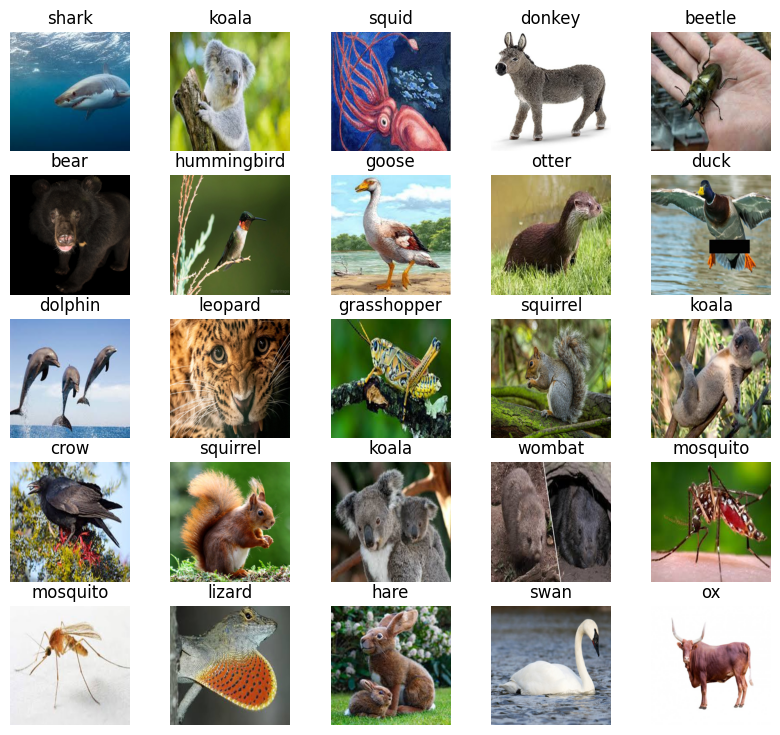

In [9]:
def plot_random_images(data=train_dir, n_rows=5, n_cols=5):
    list_images = list(Path(train_dir).glob('*/*.jpg'))
    random_images = random.sample(list_images, k=n_rows*n_cols)
    plt.figure(figsize=(10, 9))
    for i, img in enumerate(random_images):
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(Image.open(img).resize(size=(224,224)))
        plt.axis(False)
        plt.title(img.parent.name)
    plt.show()
plot_random_images()

## IV. Data Transforms and Pretrained model from torchvision.models

In [11]:
data_transform = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [12]:
from torchvision.models import efficientnet_b2, EfficientNet_B2_Weights
from torchvision.models._api import WeightsEnum
from torch.hub import load_state_dict_from_url

def get_state_dict(self, *args, **kwargs):
    kwargs.pop("check_hash")
    return load_state_dict_from_url(self.url, *args, **kwargs)
WeightsEnum.get_state_dict = get_state_dict
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = efficientnet_b2(weights=EfficientNet_B2_Weights.IMAGENET1K_V1).to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-bcdf34b7.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-bcdf34b7.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 100MB/s]


In [15]:
summary(model=model,
        input_size=(10, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"]
)

Layer (type:depth-idx)                                  Input Shape               Output Shape              Param #                   Trainable
EfficientNet                                            [10, 3, 224, 224]         [10, 1000]                --                        True
├─Sequential: 1-1                                       [10, 3, 224, 224]         [10, 1408, 7, 7]          --                        True
│    └─Conv2dNormActivation: 2-1                        [10, 3, 224, 224]         [10, 32, 112, 112]        --                        True
│    │    └─Conv2d: 3-1                                 [10, 3, 224, 224]         [10, 32, 112, 112]        864                       True
│    │    └─BatchNorm2d: 3-2                            [10, 32, 112, 112]        [10, 32, 112, 112]        64                        True
│    │    └─SiLU: 3-3                                   [10, 32, 112, 112]        [10, 32, 112, 112]        --                        --
│    └─Sequential: 2-2  

In [ ]:
model.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=1000, bias=True)
)

In [16]:
for param in model.features.parameters():
    param.requires_grad=False
model.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1408, out_features=90, bias=True)
)
summary(model=model,
        input_size=(10, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"]
)

Layer (type:depth-idx)                                  Input Shape               Output Shape              Param #                   Trainable
EfficientNet                                            [10, 3, 224, 224]         [10, 90]                  --                        Partial
├─Sequential: 1-1                                       [10, 3, 224, 224]         [10, 1408, 7, 7]          --                        False
│    └─Conv2dNormActivation: 2-1                        [10, 3, 224, 224]         [10, 32, 112, 112]        --                        False
│    │    └─Conv2d: 3-1                                 [10, 3, 224, 224]         [10, 32, 112, 112]        (864)                     False
│    │    └─BatchNorm2d: 3-2                            [10, 32, 112, 112]        [10, 32, 112, 112]        (64)                      False
│    │    └─SiLU: 3-3                                   [10, 32, 112, 112]        [10, 32, 112, 112]        --                        --
│    └─Sequential

## V. Create dataloader for train, validation and test

In [17]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
def create_dataloaders(data_train=train_dir,
                       data_validation=val_dir,
                       transforms=data_transform,
                       batch_size=10,
                       num_workers=2):
    train_data = ImageFolder(root=data_train,
                               transform=transforms,
                               )
    val_data = ImageFolder(root=data_validation,
                               transform=transforms,
                               )
    class_names = train_data.classes

    train_dataloader = DataLoader(dataset=train_data,
                                  batch_size=batch_size,
                                  shuffle=True,
                                  num_workers=num_workers,
                                  pin_memory=True)
    val_dataloader = DataLoader(dataset=val_data,
                                batch_size=batch_size,
                                shuffle=False,
                                num_workers=num_workers,
                                pin_memory=True)
    return train_dataloader, val_dataloader, class_names
train_dataloader, val_dataloader, class_names = create_dataloaders()

In [18]:
class_names

['antelope',
 'badger',
 'bat',
 'bear',
 'bee',
 'beetle',
 'bison',
 'boar',
 'butterfly',
 'cat',
 'caterpillar',
 'chimpanzee',
 'cockroach',
 'cow',
 'coyote',
 'crab',
 'crow',
 'deer',
 'dog',
 'dolphin',
 'donkey',
 'dragonfly',
 'duck',
 'eagle',
 'elephant',
 'flamingo',
 'fly',
 'fox',
 'goat',
 'goldfish',
 'goose',
 'gorilla',
 'grasshopper',
 'hamster',
 'hare',
 'hedgehog',
 'hippopotamus',
 'hornbill',
 'horse',
 'hummingbird',
 'hyena',
 'jellyfish',
 'kangaroo',
 'koala',
 'ladybugs',
 'leopard',
 'lion',
 'lizard',
 'lobster',
 'mosquito',
 'moth',
 'mouse',
 'octopus',
 'okapi',
 'orangutan',
 'otter',
 'owl',
 'ox',
 'oyster',
 'panda',
 'parrot',
 'pelecaniformes',
 'penguin',
 'pig',
 'pigeon',
 'porcupine',
 'possum',
 'raccoon',
 'rat',
 'reindeer',
 'rhinoceros',
 'sandpiper',
 'seahorse',
 'seal',
 'shark',
 'sheep',
 'snake',
 'sparrow',
 'squid',
 'squirrel',
 'starfish',
 'swan',
 'tiger',
 'turkey',
 'turtle',
 'whale',
 'wolf',
 'wombat',
 'woodpecker',


In [19]:
len(train_dataloader)

360

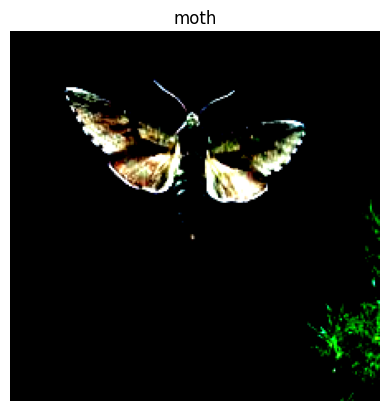

In [21]:
# Plot first image in train_dataloader
img, label = next(iter(train_dataloader))
plt.imshow(img[0].permute(1,2,0))
plt.title(class_names[label[0]])
plt.axis(False)
plt.show()

## VI. Loss function and Optimizer for train model

In [22]:
"""
Contains functions for training and testing a PyTorch model.
"""
import torch

from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn()(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn()(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:

    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "val_loss": [],
               "val_acc": []
    }

    # Make sure model on target device
    model.to(device)

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"val_loss: {test_loss:.4f} | "
          f"val_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["val_loss"].append(test_loss)
        results["val_acc"].append(test_acc)

    # Return the filled results at the end of the epochs
    return results

In [23]:
loss_fn = nn.CrossEntropyLoss
optimizer = optim.Adam(params=model.parameters(), lr=0.001)

In [24]:
result_model = train(model,
                    train_dataloader,
                    val_dataloader,
                    optimizer,
                    loss_fn,
                    10,
                    device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.3893 | train_acc: 0.5617 | val_loss: 1.1781 | val_acc: 0.8300
Epoch: 2 | train_loss: 0.8568 | train_acc: 0.8292 | val_loss: 0.7350 | val_acc: 0.8644
Epoch: 3 | train_loss: 0.5988 | train_acc: 0.8694 | val_loss: 0.5601 | val_acc: 0.8911
Epoch: 4 | train_loss: 0.4715 | train_acc: 0.8944 | val_loss: 0.5213 | val_acc: 0.8778
Epoch: 5 | train_loss: 0.3703 | train_acc: 0.9169 | val_loss: 0.4518 | val_acc: 0.8933
Epoch: 6 | train_loss: 0.3252 | train_acc: 0.9256 | val_loss: 0.4266 | val_acc: 0.9011
Epoch: 7 | train_loss: 0.3022 | train_acc: 0.9308 | val_loss: 0.4162 | val_acc: 0.8922
Epoch: 8 | train_loss: 0.2602 | train_acc: 0.9383 | val_loss: 0.4132 | val_acc: 0.8889
Epoch: 9 | train_loss: 0.2539 | train_acc: 0.9375 | val_loss: 0.4201 | val_acc: 0.8922
Epoch: 10 | train_loss: 0.2203 | train_acc: 0.9458 | val_loss: 0.3892 | val_acc: 0.8944


## VII. Plot loss, accuracy curve and Test model



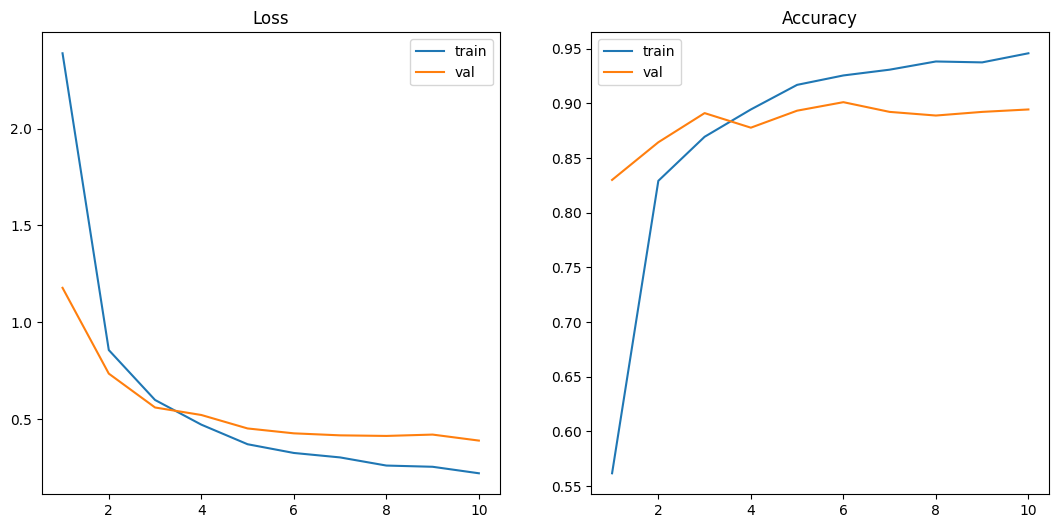

In [25]:
def plot_loss_and_acc_curve(df):
    plt.figure(figsize=(13, 6))
    plt.subplot(1, 2, 1)
    plt.plot(list(range(1, 11)), df['train_loss'], label='train')
    plt.plot(list(range(1, 11)), df['val_loss'], label='val')
    plt.title('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(list(range(1, 11)), df['train_acc'], label='train')
    plt.plot(list(range(1, 11)), df['val_acc'], label='val')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

plot_loss_and_acc_curve(result_model)

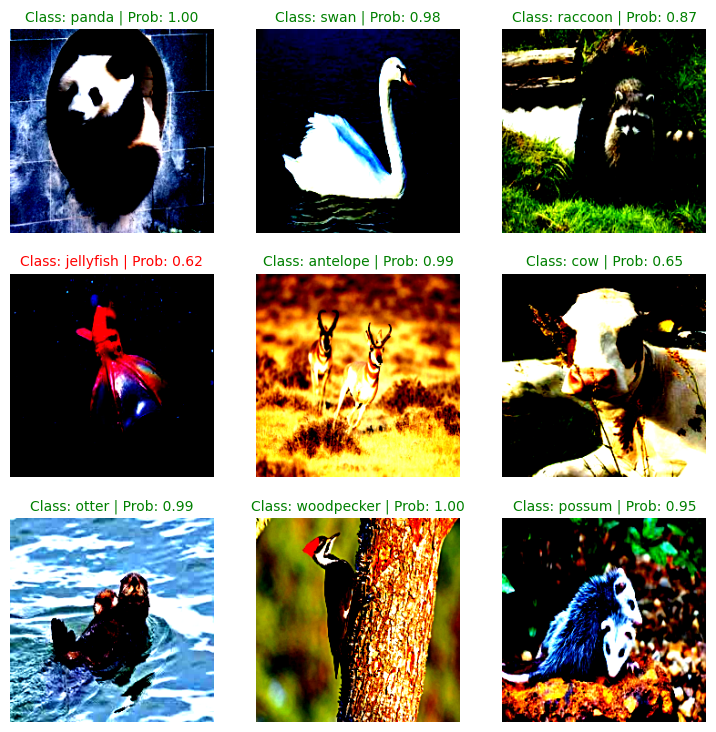

In [28]:
def prediction_k_sample(test_dir=test_dir, nrows=3, ncols=3, model=model, transforms=data_transform):
    from PIL import Image
    import random
    list_images = list(Path(test_dir).glob('*/*.jpg'))
    random_images = list(random.sample(list_images, k=nrows*ncols))
    model.eval()
    with torch.inference_mode():
        plt.figure(figsize=(9, 9))
        for i in range(nrows*ncols):
            plt.subplot(nrows, ncols, i + 1)
            img = Image.open(random_images[i])
            img_tf = transforms(img)
            y_logit = model(img_tf.unsqueeze(dim=0).to(device))
            y_pred = y_logit.argmax(dim=1)
            y_pred_prob = y_logit.softmax(dim=1).squeeze()
            prob = y_pred_prob[y_pred]
            plt.imshow(img_tf.permute(1, 2, 0))
            truth = random_images[i].parent.name
            if truth == class_names[y_pred]:
                plt.title(f'Class: {class_names[y_pred]} | Prob: {prob.item():.2f}', size=10, c='g')
            else:
                plt.title(f'Class: {class_names[y_pred]} | Prob: {prob.item():.2f}', size=10, c='r')
            plt.axis(False)
prediction_k_sample()

## VII. Plot confusion matrix

In [30]:
y_true = [i.parent.name for i in list(Path(test_dir).glob('*/*.jpg'))]
y_true

['cockroach',
 'cockroach',
 'cockroach',
 'cockroach',
 'cockroach',
 'cockroach',
 'cockroach',
 'cockroach',
 'cockroach',
 'cockroach',
 'crab',
 'crab',
 'crab',
 'crab',
 'crab',
 'crab',
 'crab',
 'crab',
 'crab',
 'crab',
 'raccoon',
 'raccoon',
 'raccoon',
 'raccoon',
 'raccoon',
 'raccoon',
 'raccoon',
 'raccoon',
 'raccoon',
 'raccoon',
 'wombat',
 'wombat',
 'wombat',
 'wombat',
 'wombat',
 'wombat',
 'wombat',
 'wombat',
 'wombat',
 'wombat',
 'bear',
 'bear',
 'bear',
 'bear',
 'bear',
 'bear',
 'bear',
 'bear',
 'bear',
 'bear',
 'shark',
 'shark',
 'shark',
 'shark',
 'shark',
 'shark',
 'shark',
 'shark',
 'shark',
 'shark',
 'hare',
 'hare',
 'hare',
 'hare',
 'hare',
 'hare',
 'hare',
 'hare',
 'hare',
 'hare',
 'donkey',
 'donkey',
 'donkey',
 'donkey',
 'donkey',
 'donkey',
 'donkey',
 'donkey',
 'donkey',
 'donkey',
 'deer',
 'deer',
 'deer',
 'deer',
 'deer',
 'deer',
 'deer',
 'deer',
 'deer',
 'deer',
 'squirrel',
 'squirrel',
 'squirrel',
 'squirrel',
 'squirr

In [31]:
from PIL import Image
y_pred = []
y_pred_prob = []
list_images = list(Path(test_dir).glob('*/*.jpg'))
for img in list_images:
    model.eval()
    with torch.inference_mode():
        image = Image.open(img)
        transformed_image = data_transform(image).unsqueeze(dim=0)
        y_logit = model(transformed_image.to(device))
        y_prob = y_logit.softmax(dim=1).max(dim=1)
        y_pred_prob.append(y_prob.values.item())
        y_pred_label = y_logit.argmax(dim=1)
        y_pred.append(class_names[y_pred_label.item()])

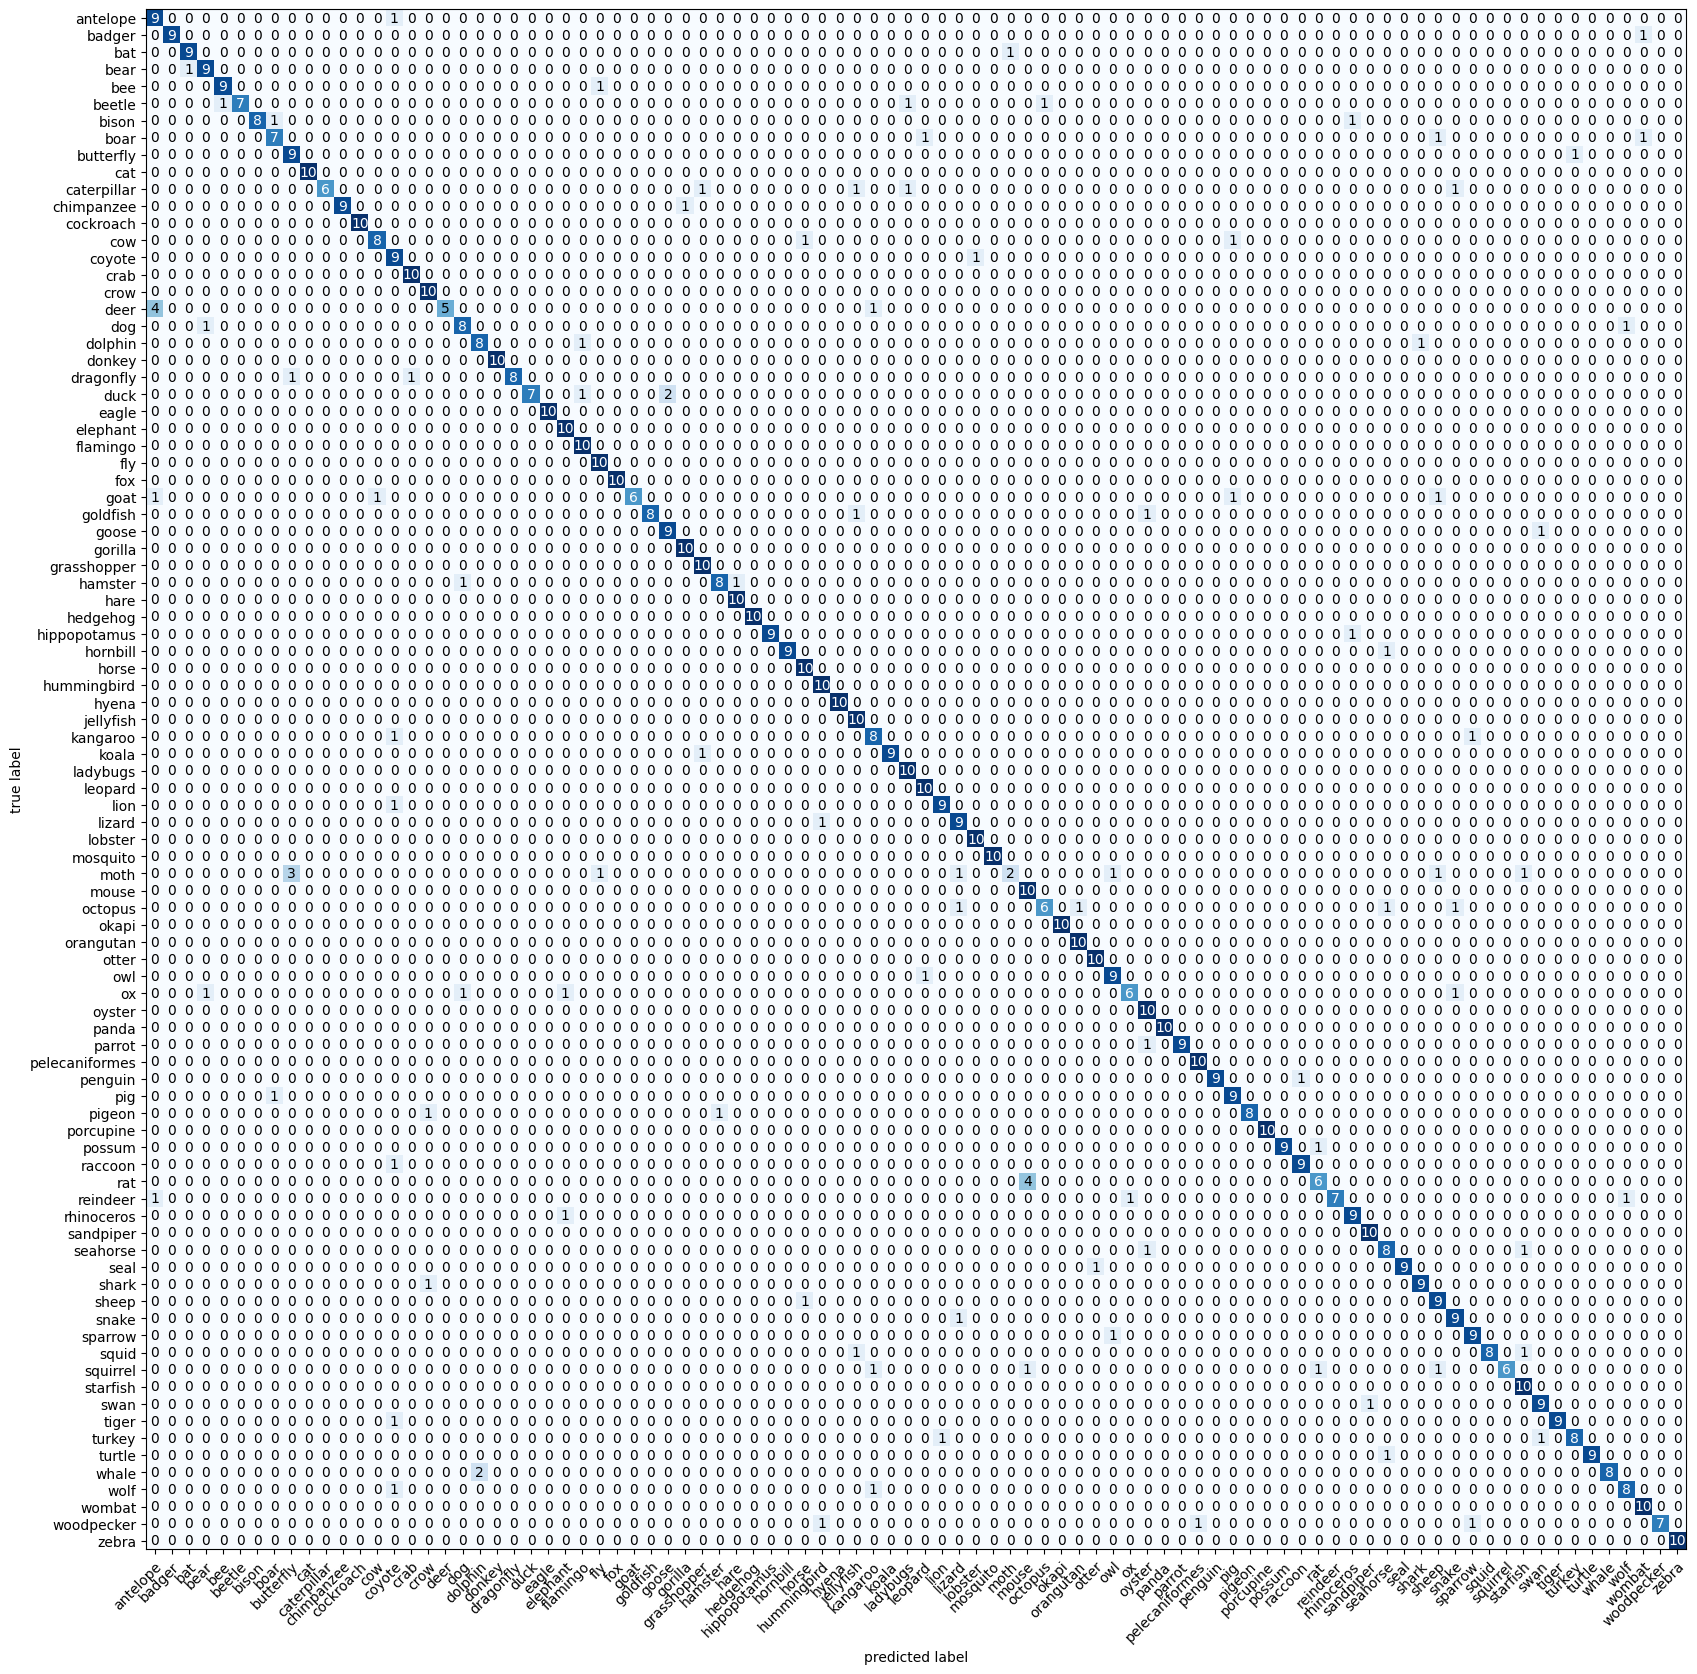

In [33]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true,y_pred)
fig, ax = plot_confusion_matrix(
    conf_mat=cm,
    class_names=class_names,
    figsize=(25, 20),
);

In [44]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=class_names))

                precision    recall  f1-score   support

      antelope       0.60      0.90      0.72        10
        badger       1.00      0.90      0.95        10
           bat       0.90      0.90      0.90        10
          bear       0.82      0.90      0.86        10
           bee       0.90      0.90      0.90        10
        beetle       1.00      0.70      0.82        10
         bison       1.00      0.80      0.89        10
          boar       0.78      0.70      0.74        10
     butterfly       0.69      0.90      0.78        10
           cat       1.00      1.00      1.00        10
   caterpillar       1.00      0.60      0.75        10
    chimpanzee       1.00      0.90      0.95        10
     cockroach       1.00      1.00      1.00        10
           cow       0.89      0.80      0.84        10
        coyote       0.60      0.90      0.72        10
          crab       0.91      1.00      0.95        10
          crow       0.83      1.00      0.91  

## IX. Plot 5 most wrong predictions

In [40]:
import pandas as pd
dt = {
    'sample': [],
    'label': [],
    'prediction': [],
    'pred prob': []
}
dt['sample'] = list_images
dt['label'] = y_true
dt['prediction'] = y_pred
dt['pred prob'] = y_pred_prob
df = pd.DataFrame(dt)
wrong_df = df.where(df['label'] != df['prediction']).dropna()
wrong_df.sort_values(by='pred prob', axis=0, ascending=False, inplace=True)
most_wrong_predict = list(wrong_df.head()['sample'])
wrong_data = wrong_df.head().drop(labels='sample', axis=1)
wrong_label_prob = [f'Truth: {i[0]} | Pred: {i[1]} | Prob: {"{:.2f}".format(i[2])}' for i in wrong_data.values]
# Most 5 wrong predictions with transformed images
def plot_most_wrong_transform_mode(list_wrong):
    plt.figure(figsize=(15, 6))
    for i, img in enumerate(list_wrong):
        plt.subplot(1, 5, i + 1)
        image = Image.open(img)
        tf = data_transform(image)
        plt.imshow(tf.permute(1,2,0))
        plt.title(wrong_label_prob[i],size=8, c='r')
        plt.axis(False)
    plt.show()

# Most 5 wrong predictions with no transformed images
def plot_most_wrong_no_transform_mode(list_wrong):
    plt.figure(figsize=(15, 6))
    for i, img in enumerate(list_wrong):
        plt.subplot(1, 5, i + 1)
        image = Image.open(img)
        plt.imshow(image)
        plt.title(wrong_label_prob[i],size=8, c='r')
        plt.axis(False)
    plt.show()

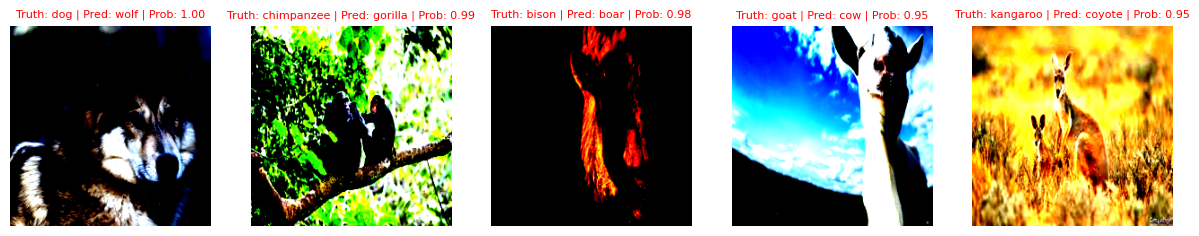

In [41]:
plot_most_wrong_transform_mode(most_wrong_predict)

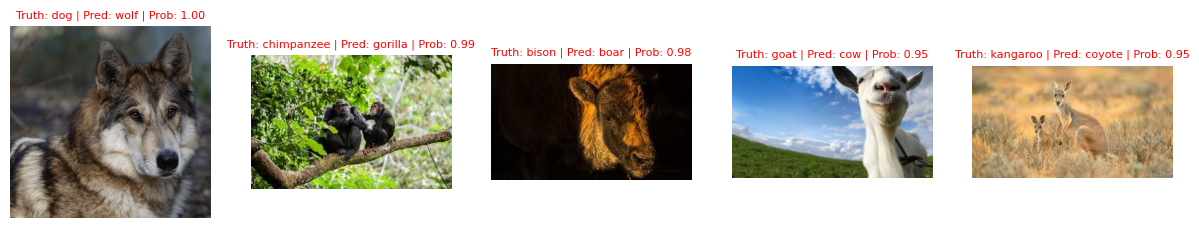

In [42]:
plot_most_wrong_no_transform_mode(most_wrong_predict)